In [1]:
# this notebook tries to test the model against data from R265 (AFTER CLEANSING)

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pymssql
# import pyodbc as pdc
import sqlalchemy as sa

import urllib.parse

import re
import tqdm

import plotly.express as px
import os


import warnings
warnings.filterwarnings('ignore')


server='40.123.229.239'
username='smartae'
password = os.getenv('SQL_PASSWORD')
database='master'
encoded_password = urllib.parse.quote_plus(password)

conn = pymssql.connect(server, username, password, "master")
cursor = conn.cursor(as_dict=True)

import pickle

In [3]:
df=pd.read_csv('../SQLMasterMetaData2.csv').drop(['Unnamed: 0'],axis=1)
df[df['TABLE_NAME'].str.contains('R265')].TABLE_NAME.values

parameters={'vsd_freq': 'R265_1_CH1_VSD_OUTFREQ',
          'total_kW': 'R265_1_CH1_METER_TOTAL_ACTIVE_POWER',
          'sup_temp': 'R265_1_CH1_SUP_WTRTEMP', 'ret_temp': 'R265_1_CH1_RET_WTRTEMP', 'ch2_total_kW': 'R265_1_CH2_METER_TOTAL_ACTIVE_POWER',
          }

ch_parms=list(parameters.values())
labels=list(parameters.keys())


In [4]:
ignored=[]
res=pd.DataFrame()
for i,point in enumerate(ch_parms[:]):
        
    query1=f"""SELECT 
        Timestamp,[VALUE] as {labels[i]}
        FROM [niagara].[dbo].{point}
        where timestamp < '2023-09-01'
        and timestamp > '2019-09-17'
        """
    tempdf=pd.read_sql(query1,conn)
    if len(tempdf)<10000:
        print(point,'==> IGNORED!!!')
        ignored.append(point)
        continue
    tempdf=tempdf.groupby(pd.Grouper(key='Timestamp',freq='15min')).mean().round(2).dropna()
    res=res.join(tempdf,how='outer')

res


,vsd_freq,total_kW,sup_temp,ret_temp,ch2_total_kW
Timestamp,,,,,
2019-09-17 00:00:00,93.5,69.54,7.1,8.9,0.47
2019-09-17 00:15:00,94.0,69.79,7.1,9.0,0.47
2019-09-17 00:30:00,92.1,68.89,7.0,8.8,0.47
2019-09-17 00:45:00,97.1,72.46,7.2,9.1,0.47
2019-09-17 01:00:00,100.2,75.08,7.1,9.1,0.47
...,...,...,...,...,...
2023-08-31 22:45:00,102.9,76.51,6.6,11.1,0.64
2023-08-31 23:00:00,103.6,77.47,6.5,11.1,0.64
2023-08-31 23:15:00,102.5,76.38,6.5,10.9,0.65


In [5]:
# which method of approximation is the most accurate
d1=res.copy()

# optimized temp 2 (weather.com data)
temp=pd.read_csv('amb_temp_hr.csv',index_col='Timestamp')
temp.index=pd.to_datetime(temp.index)
d1=d1.groupby(pd.Grouper(freq='1h')).mean().iloc[1:]
d1['amb_temp']=temp

d1=d1[~d1[['total_kW','amb_temp']].isna().any(axis=1)]

d1['ch1_run_sts']=d1.total_kW.apply(lambda x: 1 if x>10 else 0)
d1['ch2_run_sts']=d1.ch2_total_kW.apply(lambda x: 1 if x>10 else 0)

d1['dT']=d1.apply(lambda x: max(0,x.ret_temp-x.sup_temp),axis=1)

d1





,vsd_freq,total_kW,sup_temp,ret_temp,ch2_total_kW,amb_temp,ch1_run_sts,ch2_run_sts,dT
Timestamp,,,,,,,,,
2019-09-21 14:00:00,0.000,0.736667,9.433333,9.733333,85.5300,38.0,0,1,0.300
2019-09-21 15:00:00,0.000,0.740000,8.875000,9.175000,80.3950,37.0,0,1,0.300
2019-09-21 16:00:00,78.925,56.475000,7.600000,9.350000,18.6625,36.0,1,1,1.750
2019-09-21 17:00:00,95.025,71.722500,7.075000,8.950000,0.4875,36.0,1,0,1.875
2019-09-21 18:00:00,91.125,68.000000,7.075000,8.900000,0.4725,35.0,1,0,1.825


<AxesSubplot: xlabel='cload_%', ylabel='Count'>

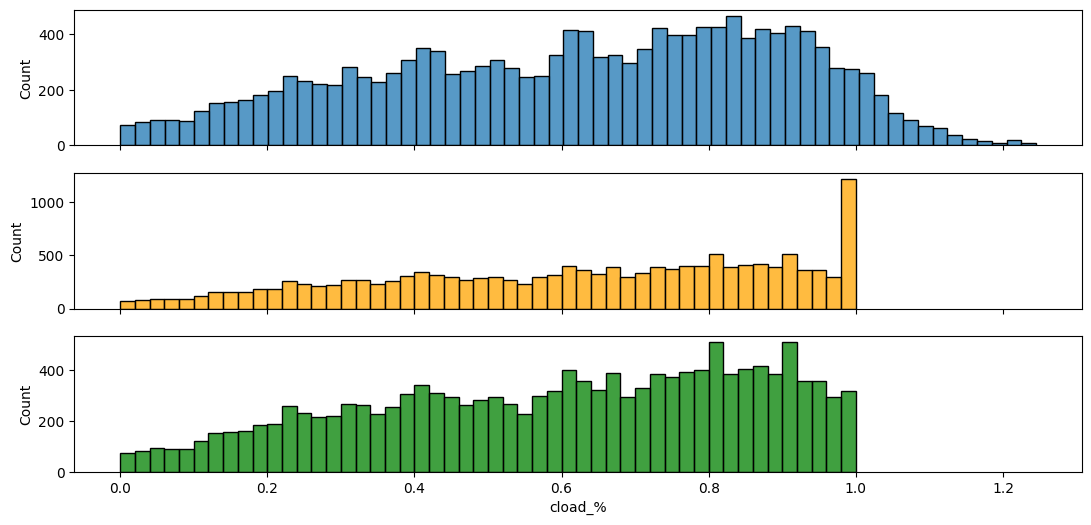

In [6]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=[13,6],sharex=True)
# ax.set_xticklabels(ax.get_xticklabels())
dd=d1.copy()
# sometimes there are 6 pumps running for a single chiller !!!
dd['cload']=dd.dT

dd['full_cload']= 5 

# cload      = flow      * cp * dT
# full_cload = max_flow  * cp * max_dT = 300 * cp * 5
# flow = max_flow =100
# cload%=cload/full_cload = dT/max_dT

dd['cload_%']=dd.apply(lambda x: x.cload/x.full_cload,axis=1)
dd['cload_%_']=dd.apply(lambda x: min(1,x.cload/x.full_cload),axis=1)

dd=dd[(dd.sup_temp>=6)&(dd.sup_temp<=10)] # only care when it is running and sup temp is valid
dd=dd[(dd.ret_temp>=9)&(dd.ret_temp<=14)] # only care when it is running and ret temp is valid

dd=dd[(dd.ch1_run_sts==1)&(dd.dT>0)] # only care when it is running and dT is real
# dd=dd[dd['cload_%']<=1.00] # remove outliers 
sns.histplot(dd['cload_%'],ax=ax1,binwidth=0.02)
sns.histplot(dd['cload_%_'],color='orange',ax=ax2,binwidth=0.02)
sns.histplot(dd[dd['cload_%']<=1]['cload_%'],color='green',ax=ax3,binwidth=0.02)
# sns.histplot(np.log1p(dd[dd['cload_%']<=1]['cload_%']),color='green',ax=ax3)

<AxesSubplot: >

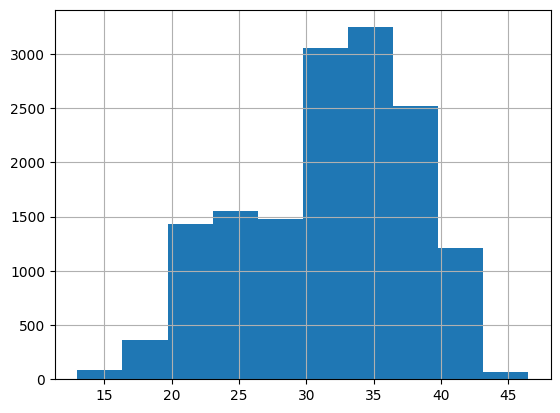

In [7]:
dd.amb_temp.hist()

### Extra Cleaning and optimizing

### visualizing

<AxesSubplot: xlabel='cload_%_', ylabel='total_kW'>

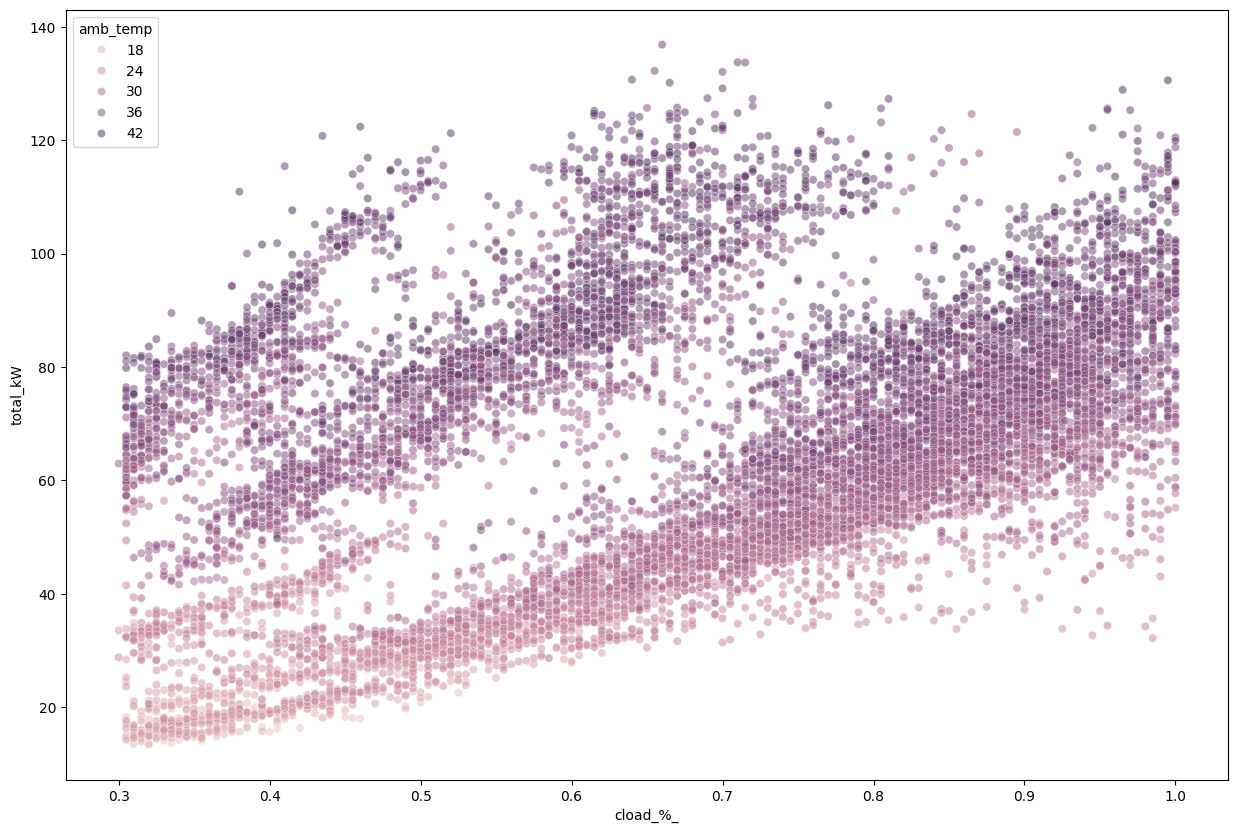

In [8]:
dd=dd[(dd['cload_%']<=1)&(dd['cload_%']>0.3)] # non-vfd limit is 0.3 and vfd limit is 0.1, but we need to compare to non-vfd so we remove <0.3
dd2=dd.copy()
# dd2=dd2.groupby(pd.Grouper(freq='1d')).mean()
fig,ax=plt.subplots(figsize=[15,10])
# dd2.groupby(pd.Grouper(key=dd2.index, freq='1h')).mean()
sns.scatterplot(y=dd2.total_kW,x=dd2['cload_%_'],hue=dd2.amb_temp,ax=ax,alpha=0.5)

<AxesSubplot: >

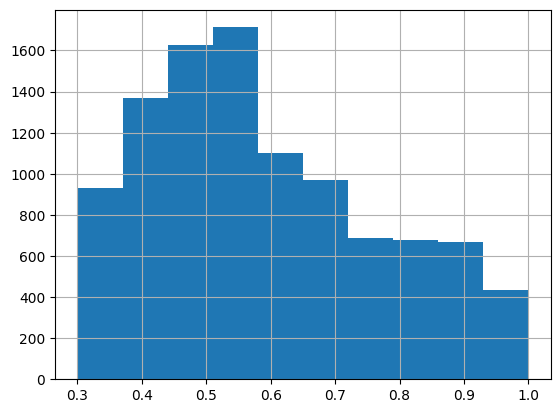

In [9]:
from scipy import interpolate
old=pd.read_csv('Recip_comp_ch.csv')
f=interpolate.interp1d(old['capacity%'],old['power%'],fill_value='extrapolate')
max_power=max(dd.total_kW)
dd['old_max_kW']=f(dd['cload_%_'])*max_power
dd['power_%']=dd.apply(lambda x: x.total_kW/x.old_max_kW,axis=1)
dd=dd[(dd['power_%']<=1)&(dd['power_%']>0.3)]

dd['power_%'].hist()

array(0.04)

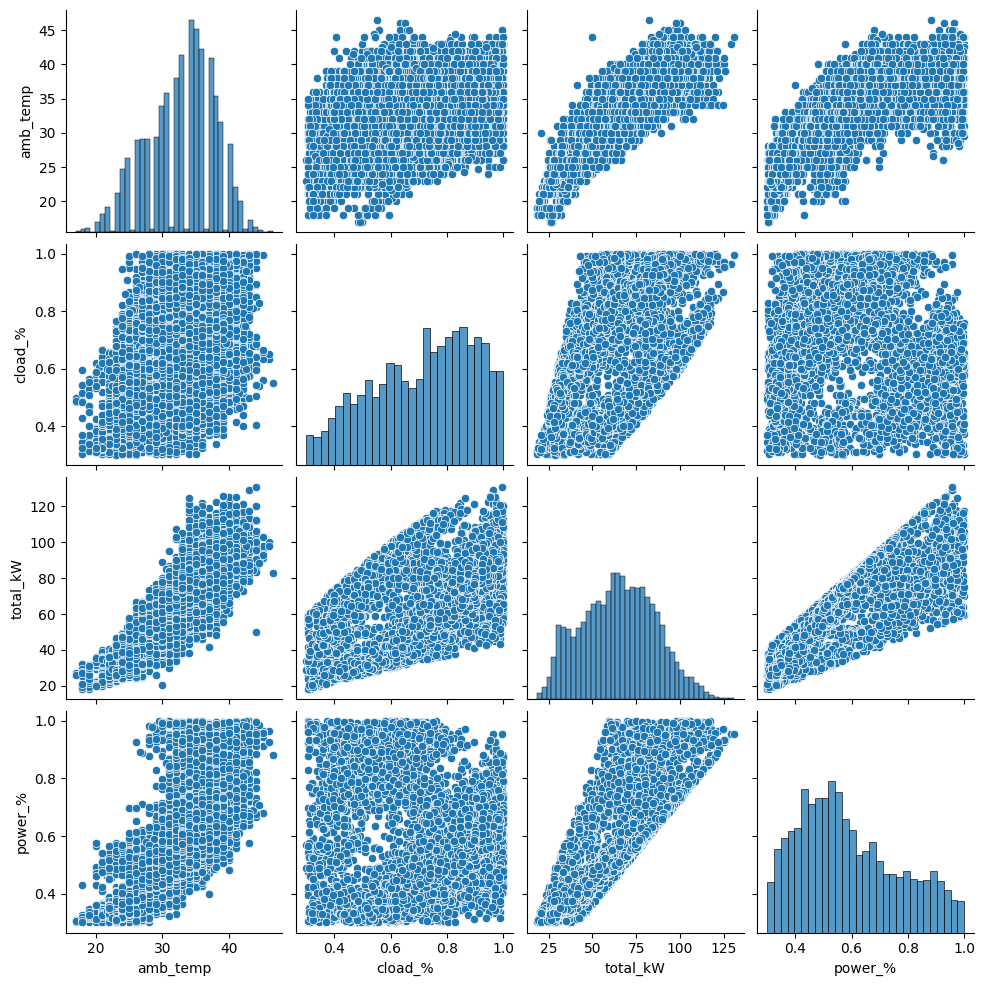

In [10]:
r=dd.copy()
r=r[['amb_temp','cload_%','total_kW','power_%']]
sns.pairplot(r)
f(0.0)

In [11]:

m1='XGB_m_2'
m2='XGB_m_1'
with open(f'models/{m1}.pkl','rb') as f:
    model1=pickle.load(f)
with open(f'models/{m2}.pkl','rb') as f:
    model2=pickle.load(f)



### Hourly Results

hourly results
XGB_m_2
Error: 0.15580217921805126
XGB_m_1
Error: 0.17254866632919477


Text(0.5, 1.0, 'XGB_m_1')

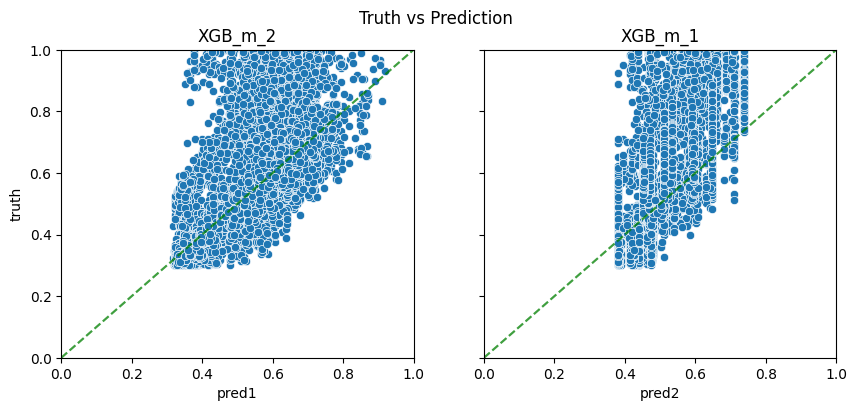

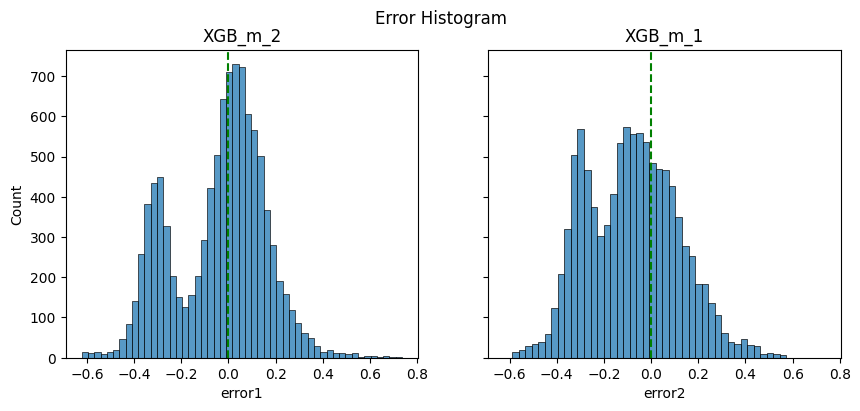

In [12]:
tt1=r.copy()
tt1['pred1']=model1.predict(tt1[['amb_temp', 'cload_%']])
tt1['pred2']=model2.predict(tt1[['amb_temp', 'cload_%']])
tt1['truth']=tt1['power_%']
tt1['error1']=tt1.apply(lambda x: (x.pred1-x.truth)/x.truth,axis=1)
tt1['error2']=tt1.apply(lambda x: (x.pred2-x.truth)/x.truth,axis=1)
print('hourly results')
print(f'{m1}\nError:',abs(tt1.error1).mean())
print(f'{m2}\nError:',abs(tt1.error2).mean())
# tt1
# region plot
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[10,4],sharey=True,sharex=True)
sns.scatterplot(x=tt1.pred1,y=tt1.truth,ax=ax1)
sns.scatterplot(x=tt1.pred2,y=tt1.truth,ax=ax2)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax1)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax2)
plt.suptitle('Truth vs Prediction')

ax1.set_title(m1)
ax2.set_title(m2)
ax1.set_ylim([0,1])
ax1.set_xlim([0,1])

fig,(ax3,ax4)=plt.subplots(1,2,figsize=[10,4],sharey=True,sharex=True)
sns.histplot(x=tt1.error1,ax=ax3)
ax3.axvline(x=0, color='green', linestyle='--', label='0')
sns.histplot(x=tt1.error2,ax=ax4)
ax4.axvline(x=0, color='green', linestyle='--', label='0')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax1)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax2)
plt.suptitle('Error Histogram')
# plt.axvline(x=0, color='green', linestyle='-', label='0',ax=ax4)

ax3.set_title(m1)
ax4.set_title(m2)


# endregion

### Daily Results

MonthEnd results
Model1
Error: 0.1744491652815684
Model2
Error: 0.1981295357468905


Text(0.5, 1.0, 'XGB_m_1')

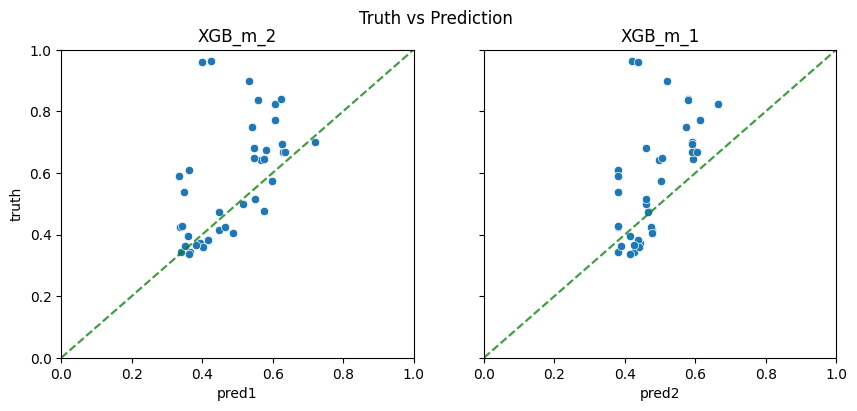

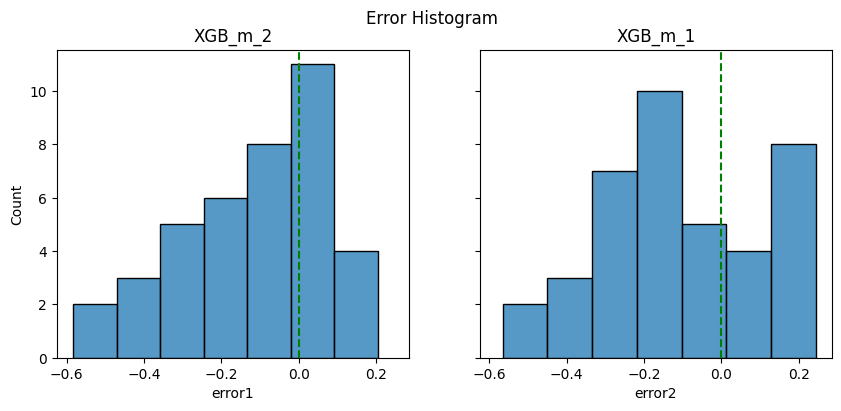

In [13]:
g=pd.Grouper(freq='m')
tt1=r.copy().groupby(g).mean()
tt1['pred1']=model1.predict(tt1[['amb_temp', 'cload_%']])
tt1['pred2']=model2.predict(tt1[['amb_temp', 'cload_%']])
tt1['truth']=tt1['power_%']
tt1['error1']=tt1.apply(lambda x: (x.pred1-x.truth)/x.truth,axis=1)
tt1['error2']=tt1.apply(lambda x: (x.pred2-x.truth)/x.truth,axis=1)
print(f'{str(g.freq)[1:-1]} results')
print('Model1\nError:',abs(tt1.error1).mean())
print('Model2\nError:',abs(tt1.error2).mean())
# tt1
# region plot
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[10,4],sharey=True,sharex=True)
sns.scatterplot(x=tt1.pred1,y=tt1.truth,ax=ax1)
sns.scatterplot(x=tt1.pred2,y=tt1.truth,ax=ax2)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax1)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax2)
plt.suptitle('Truth vs Prediction')

ax1.set_title(m1)
ax2.set_title(m2)
ax1.set_ylim([0,1])
ax1.set_xlim([0,1])

fig,(ax3,ax4)=plt.subplots(1,2,figsize=[10,4],sharey=True,sharex=True)
sns.histplot(x=tt1.error1,ax=ax3)
ax3.axvline(x=0, color='green', linestyle='--', label='0')
sns.histplot(x=tt1.error2,ax=ax4)
ax4.axvline(x=0, color='green', linestyle='--', label='0')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax1)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax2)
plt.suptitle('Error Histogram')
# plt.axvline(x=0, color='green', linestyle='-', label='0',ax=ax4)

ax3.set_title(m1)
ax4.set_title(m2)
# endregion

### Clustering Data to study patterns

<AxesSubplot: xlabel='cload_%_', ylabel='total_kW'>

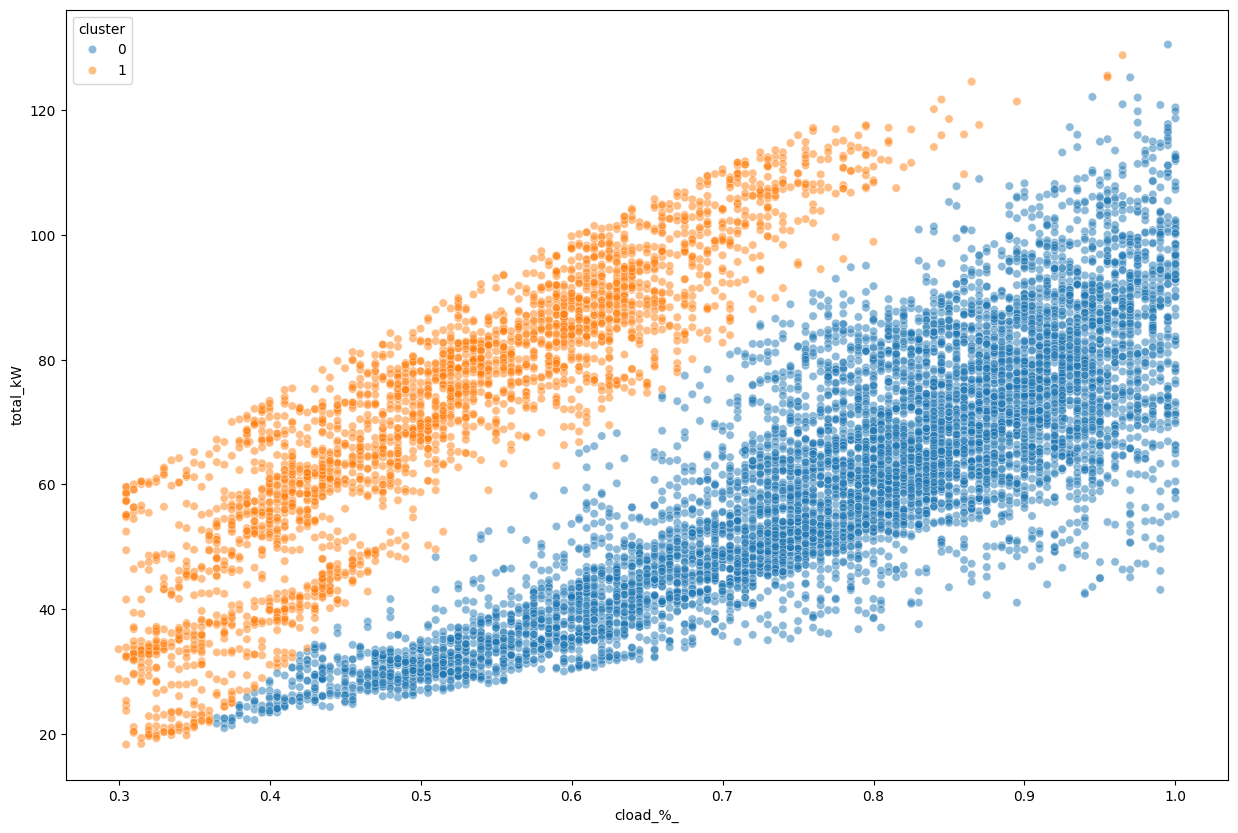

In [14]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering,Birch
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler((0,1))
cluster=KMeans(n_clusters=2)
cluster=SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=3)
cluster=GaussianMixture(n_components=2)
# cluster=Birch(threshold=0.05, n_clusters=4)
# cluster= DBSCAN(eps=0.3, min_samples=2)
dd_=dd.copy()
dd_['scaled_kW']=sc.fit_transform(dd_[['total_kW']])
cluster.fit(dd_[['cload_%_','scaled_kW']])
# dd_['cluster']=cluster.labels_
dd_['cluster']=cluster.predict(dd_[['cload_%_','scaled_kW']])
# dd
fig,ax=plt.subplots(figsize=[15,10])
# dd2.groupby(pd.Grouper(key=dd2.index, freq='1h')).mean()
sns.scatterplot(y=dd_.total_kW,x=dd_['cload_%_'],hue=dd_.cluster,ax=ax,alpha=0.5)


In [15]:
def AB_Test(dataframe, group, target):
    
    """
    Conducts an A/B test  to compare two groups and determine if there is a statistically significant difference in their means.

    Parameters:
        - dataframe: DataFrame containing the data.
        - group: Column name that defines the groups A and B
        - target: Column name representing the metric or variable of interest.

    Returns:
        - A DataFrame with the A/B test results, including hypothesis outcomes, p-values, and group statistics.
    """
    
    # Step 1: Split Data into Groups (Group A and Group B)
    # Step 2: Check Normality Assumption
        # Step 3a: If Both Groups Are Normally Distributed, Check Homogeneity of Variances and Perform a Parametric t-test
        # Step 3b: If Either Group Is Not Normally Distributed, Perform a Non-Parametric Test
    # Step 4: Create a Summary DataFrame with Test Results and Group Statistics
    
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    dataframe=dataframe.dropna()
    # Split A/B
    groupA = dataframe[dataframe[group] == 1][target]
    groupB = dataframe[dataframe[group] == 0][target]
    
    # ======= Assumption: Normality
    # Check for normality using the Shapiro-Wilk test
    # H0: Distribution is Normal (False if p-value < 0.05)
    # H1: Distribution is not Normal (True if p-value < 0.05)
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    
    if (ntA == False) & (ntB == False): # If both groups are normally distributed
        # Parametric Test
        # ======= Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            # Perform a parametric t-test assuming equal variances
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: Means are equal (False if p-value < 0.05)
            # H1: Means are not equal (True if p-value < 0.05)
        else:
            # Heterogeneous
            # Perform a parametric t-test assuming unequal variances
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: Means are equal (False if p-value < 0.05)
            # H1: Means are not equal (True if p-value < 0.05)
    else:
        # Non-Parametric Test
        # Perform Mann-Whitney U test (Wilcoxon rank-sum test)
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: Means are equal (False if p-value < 0.05)
        # H1: Means are not equal (True if p-value < 0.05)
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":f'{ttest:.2e}'
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    temp["Feature"] = group
    temp["GroupA_mean"] = groupA.mean()
    temp["GroupB_mean"] = groupB.mean()
    temp["GroupA_median"] = groupA.median()
    temp["GroupB_median"] = groupB.median()
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Feature","Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    else:
        temp = temp[["Feature","Test Type","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    return temp

AB_Test(dd_,'cluster','total_kW')

,Feature,Test Type,AB Hypothesis,p-value,Comment,GroupA_mean,GroupB_mean,GroupA_median,GroupB_median
0,cluster,Non-Parametric,Reject H0,2.38e-94,A/B groups are not similar!,72.09962,62.454266,74.655,62.6925


In [16]:
# fig,ax=plt.subplots(figsize=[15,5])
# sns.scatterplot(dd_,x=dd_.index,y='total_kW',hue='cluster',alpha=0.5,s=2)
px.scatter(data_frame=dd_,x=dd_.index,y='total_kW',color='cluster',size_max=3)

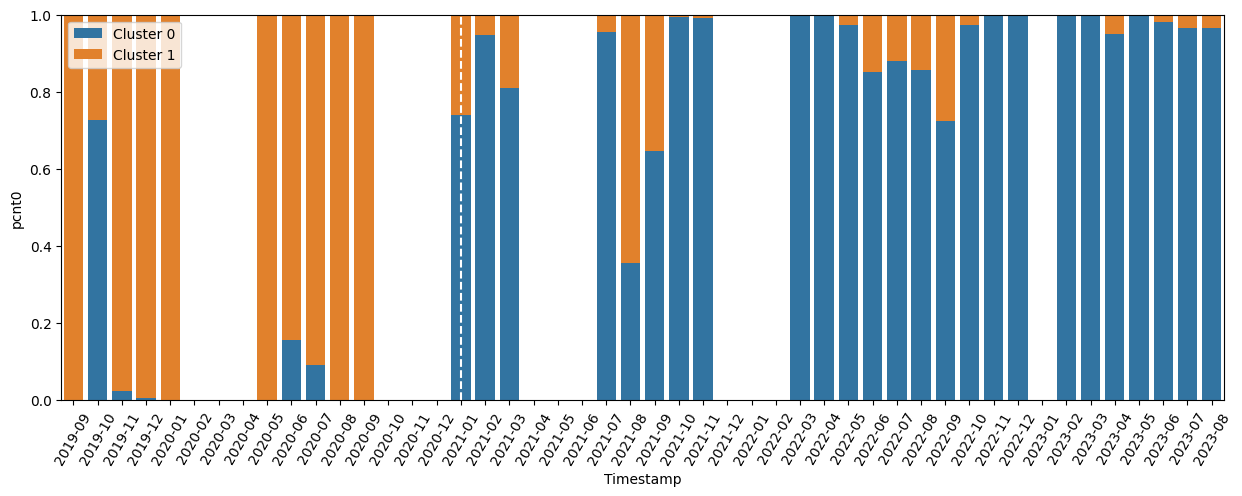

In [17]:
dd_2=dd_[['total_kW','cload_%','cluster']]
dd_2.reset_index()
dd_3=dd_2.groupby([pd.Grouper(freq='m'),'cluster']).count().reset_index()
dd_3
dd4=dd_3.pivot(index='Timestamp',columns='cluster',values='total_kW').fillna(0)
dd4['sam']=dd4[0]+dd4[1]
dd4['pcnt0']=dd4[0]/dd4.sam
dd4['pcnt1']=dd4[1]/dd4.sam

dd4[['pcnt0','pcnt1']]=dd4.apply(lambda x: pd.Series((x[0] / x['sam'], x[1] / x['sam']) if x['sam'] > 7 else (0, 0)), axis=1)
dd4=dd4.asfreq('m').fillna(0)

# sns.set('paper')
# sns.set_theme()
sns.reset_orig()
# Create the stacked bar chart
fig,ax=plt.subplots(figsize=[15,5])
sns.barplot(data=dd4, x=dd4.index, y='pcnt0', color='C0', label='Cluster 0')
sns.barplot(data=dd4, x=dd4.index, y='pcnt1', color='C1', bottom=dd4['pcnt0'], label='Cluster 1')

# custom xticklabels ('YY-mm') with rotation of 45
ls=[] # new xticklabels
for i in ax.get_xticklabels():
    i.set_text(i.get_text()[:-3])
    ls.append(i)

plt.axvline(x='2021-01-31',color='white',linestyle='--')
ax.set_xticklabels(ls, rotation=60)  # Rotate x-axis tick labels
# ax.set_xticklabels(ax.get_xticklabels(), rotation=60)  # Rotate x-axis tick labels
# dd4.apply(lambda x:(x[0]/x['sam'],x[1]/x['sam']) if x['sam']>7 else (0,0),axis=1)

plt.show()

In [40]:
# dd.loc['2020'].ch2_total_kW.hist()
dd.loc['2021'].ch2_total_kW.sum()
dd.loc['2021'].total_kW.sum()

dd.groupby(pd.Grouper(freq='y')).mean()[['total_kW','ch2_total_kW']]


,total_kW,ch2_total_kW
Timestamp,,
2019-12-31,45.053516,1.169747
2020-12-31,72.282900,0.420861
2021-12-31,57.706365,4.605883
2022-12-31,65.910208,0.822714
2023-12-31,71.179772,0.721987


In [23]:
dd.loc['2020'].ch2_total_kW.plot()

<AxesSubplot: title={'center': 'XGB_m_1'}, xlabel='Timestamp', ylabel='Count'>

#### Splitting Data for a more accurate model

In [18]:
r=dd.loc['2021':].copy()
r=r[['amb_temp','cload_%','total_kW','power_%']]
r
fig,ax=plt.subplots(figsize=[15,10])
# dd2.groupby(pd.Grouper(key=dd2.index, freq='1h')).mean()
sns.scatterplot(y=r.total_kW,x=r['cload_%'],hue=r.amb_temp,ax=ax,alpha=0.5)

<AxesSubplot: xlabel='cload_%', ylabel='total_kW'>

In [19]:
tt1=r.copy()
tt1['pred1']=model1.predict(tt1[['amb_temp', 'cload_%']])
tt1['pred2']=model2.predict(tt1[['amb_temp', 'cload_%']])
tt1['truth']=tt1['power_%']
tt1['error1']=tt1.apply(lambda x: (x.pred1-x.truth)/x.truth,axis=1)
tt1['error2']=tt1.apply(lambda x: (x.pred2-x.truth)/x.truth,axis=1)
print('hourly results')
print(f'{m1}\nError:',abs(tt1.error1).mean())
print(f'{m2}\nError:',abs(tt1.error2).mean())
# tt1
# region plot
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[10,4],sharey=True,sharex=True)
sns.scatterplot(x=tt1.pred1,y=tt1.truth,ax=ax1)
sns.scatterplot(x=tt1.pred2,y=tt1.truth,ax=ax2)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax1)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax2)
plt.suptitle('Truth vs Prediction')

ax1.set_title(m1)
ax2.set_title(m2)
ax1.set_ylim([0,1])
ax1.set_xlim([0,1])

fig,(ax3,ax4)=plt.subplots(1,2,figsize=[10,4],sharey=True,sharex=True)
sns.histplot(x=tt1.error1,ax=ax3)
ax3.axvline(x=0, color='green', linestyle='--', label='0')
sns.histplot(x=tt1.error2,ax=ax4)
ax4.axvline(x=0, color='green', linestyle='--', label='0')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax1)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax2)
plt.suptitle('Error Histogram')
# plt.axvline(x=0, color='green', linestyle='-', label='0',ax=ax4)

ax3.set_title(m1)
ax4.set_title(m2)
# endregion

hourly results
XGB_m_2
Error: 0.12382078549630743
XGB_m_1
Error: 0.14469851425720034


Text(0.5, 1.0, 'XGB_m_1')